# Chapter: Dimension Reduction and Latent Variable Methods (Part 2)¶¶

# Topic: Process Monitoring via ICA 

In [7]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          ICA model for TEP data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
# import required packages
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

In [9]:
# fetch TE data
TEdata_noFault_train = np.loadtxt('d00.dat').T # data arrnagement in d00.dat is different than that in other files

# select variables as done in Lee et al.
xmeas = TEdata_noFault_train[:,0:22]
xmv = TEdata_noFault_train[:,41:52]
data_noFault_train = np.hstack((xmeas, xmv))

In [10]:
# scale data
scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_noFault_train)

In [11]:
# fit ICA model 
ica = FastICA(max_iter=1000, tol=0.005, random_state=1).fit(data_train_normal)

In [12]:
# decide # of ICs to retain via PCA variance method and compute ICs
from sklearn.decomposition import PCA
pca = PCA().fit(data_train_normal)

explained_variance = 100*pca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained

n_comp = np.argmax(cum_explained_variance >= 90) + 1

In [13]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                     Monitoring statistics function
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [14]:
def compute_ICA_monitoring_metrics(ica_model, number_comp, data):
    """ calculate monitoring statistics for given data 
    
    parameters
    -----------
    data: numpy array of shape = [n_samples, n_features]
          Training or test data
    
    Returns
    ----------
    monitoring_stats: numpy array of shape = [n_samples, 3]
        
    """
    
    # data parameters
    n = data.shape[0]
    
    # model parameters
    W = ica.components_
    L2_norm = np.linalg.norm(W, 2, axis=1)
    sort_order = np.flip(np.argsort(L2_norm))    
    W_sorted = W[sort_order,:]
    
    # I2
    Wd = W_sorted[0:number_comp,:]
    Sd = np.dot(Wd, data.T)
    I2 = np.array([np.dot(Sd[:,i], Sd[:,i]) for i in range(n)]) 
        
    # Ie2
    We = W_sorted[n_comp:,:]
    Se = np.dot(We, data.T)
    Ie2 = np.array([np.dot(Se[:,i], Se[:,i]) for i in range(n)]) 
        
    # SPE
    Q = ica.whitening_
    Q_inv = np.linalg.inv(Q)
    A = ica.mixing_
    B = np.dot(Q, A)
    B_sorted = B[:,sort_order]
    Bd = B_sorted[:,0:n_comp]
    
    data_reconstruct = np.dot(np.dot(np.dot(Q_inv, Bd), Wd), data.T)
    e = data.T - data_reconstruct
    SPE = np.array([np.dot(e[:,i], e[:,i]) for i in range(n)])
    
    monitoring_stats = np.column_stack((I2, Ie2, SPE))
    return monitoring_stats


In [15]:
def draw_monitoring_chart(values, CL, yLabel):
    plt.figure()
    plt.plot(values)
    plt.axhline(CL, color = "red", linestyle = "--")
    plt.xlabel('Sample #')
    plt.ylabel(yLabel)
    plt.show()

def draw_ICA_monitoring_charts(ICA_statistics, CLs, trainORtest):
    """ draw monitoring charts for given data 
    
    parameters
    -----------
    ICA_statistics: numpy array of shape = [n_samples, 3]
    CLs: List of control limits
    trainORtest: 'training' or 'test'

    """
    
    # I2 chart, Ie2 chart, SPE chart
    draw_monitoring_chart(ICA_statistics[:,0], CLs[0], 'I2 for ' + trainORtest + ' data')
    draw_monitoring_chart(ICA_statistics[:,1], CLs[1], 'Ie2 for ' + trainORtest + ' data')
    draw_monitoring_chart(ICA_statistics[:,2], CLs[2], 'SPE for ' + trainORtest + ' data')

In [16]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                   Draw monitoring charts for training data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

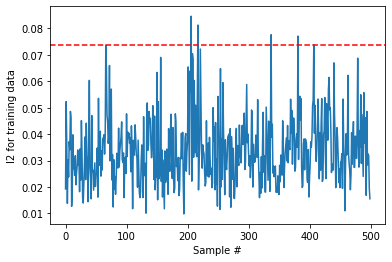

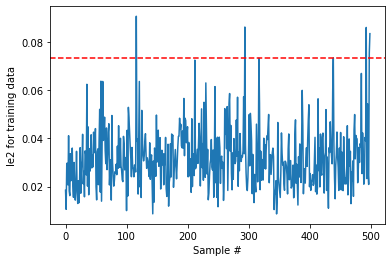

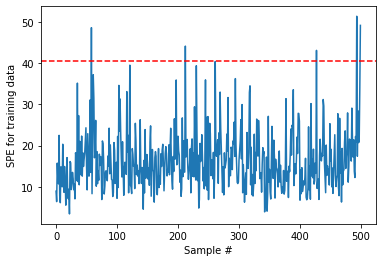

In [17]:
ICA_statistics_train = compute_ICA_monitoring_metrics(ica, n_comp, data_train_normal)

I2_CL = np.percentile(ICA_statistics_train[:,0], 99)
Ie2_CL = np.percentile(ICA_statistics_train[:,1], 99)
SPE_CL = np.percentile(ICA_statistics_train[:,2], 99)

draw_ICA_monitoring_charts(ICA_statistics_train, [I2_CL, Ie2_CL, SPE_CL], 'training')

In [18]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                   FAR / FDR computation function
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [19]:
def compute_alarmRate(monitoring_stats, CLs):
    """ calculate alarm rate 
    
    parameters
    -----------
    monitoring_stats: numpy array of shape = [n_samples, 3]
    CLs: List of control limits
    
    Returns
    ----------
    alarmRate: float
        
    """
    
    violationFlag = monitoring_stats > CLs 
    alarm_overall = np.any(violationFlag, axis=1) # violation of any metric => alarm
    alarmRate = 100*np.sum(alarm_overall)/monitoring_stats.shape[0]
    
    return alarmRate

In [20]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                   Draw monitoring charts for test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

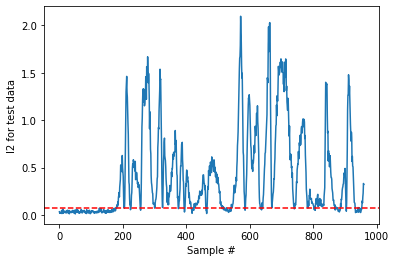

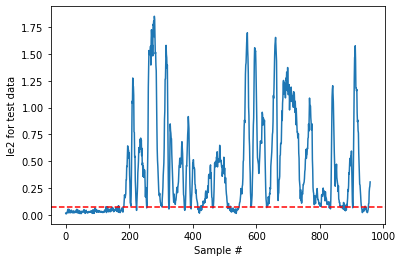

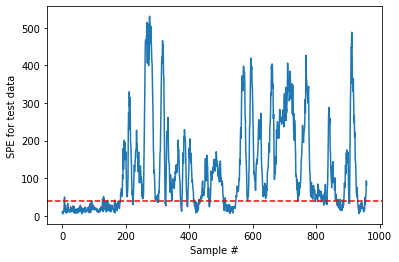

In [22]:
# fetch data and select data as done in Lee et al.
TEdata_Fault_test = np.loadtxt('d10_te.dat')

xmeas = TEdata_Fault_test[:,0:22]
xmv = TEdata_Fault_test[:,41:52]
data_Fault_test = np.hstack((xmeas, xmv))
         
# scale data
data_test_scaled = scaler.transform(data_Fault_test)

# compute statistics and draw charts
ICA_statistics_test = compute_ICA_monitoring_metrics(ica, n_comp, data_test_scaled)
draw_ICA_monitoring_charts(ICA_statistics_test, [I2_CL, Ie2_CL, SPE_CL], 'test')

In [23]:
# compute FAR or FDR
alarmRate = compute_alarmRate(ICA_statistics_test[160:,:], [I2_CL, Ie2_CL, SPE_CL]) # faults start from sample 160
print(alarmRate)

90.75
